# Disclamier

* https://www.youtube.com/watch?v=z3ZnOW-S550&ab_channel=RobMulla


# Outline

* Outlier analysis
* Forecasting horizon
* Time Series cross validation ( More solid way using sklearn-TimeSeriesSplit)
* Lag Features
* Predicting the future
* Saving models

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb

plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

# Types of Time-Series

<img src ='types_of_time_series.jpg' width='500' />

In [56]:
import os
print(os.getcwd())

/Users/kevintsai/Library/CloudStorage/Dropbox/Study/Python/Machine Learning/Time-Series/Energy Consumption


In [57]:
df = pd.read_csv('AEP_hourly.csv')


In [58]:
df.head(5)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [60]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

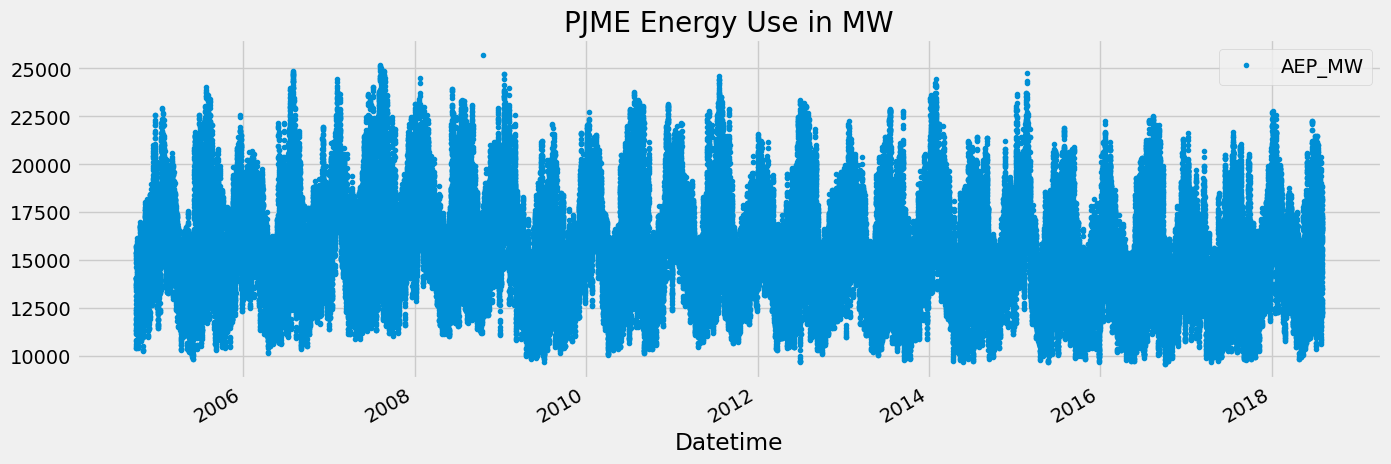

In [61]:
df.plot(style='.',
        figsize=(15,5),
        title='PJME Energy Use in MW',
        grid=True
        )

# 1. Outlier Analysis and removal

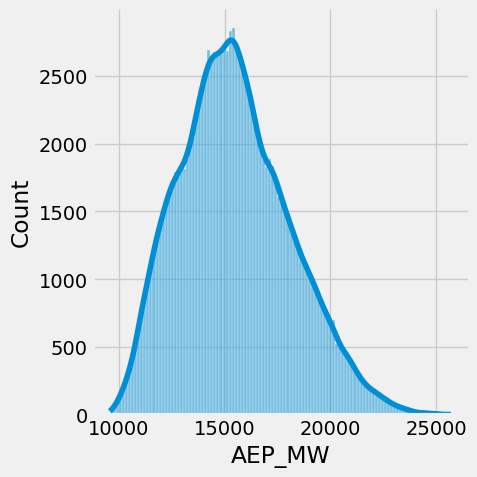

In [62]:
import seaborn as sns
sns.displot(df['AEP_MW'], kde = 'True')

In [63]:
# set lower bound : 10,000 and upper bound to 24,000
df.query(('AEP_MW <= 10_000 or AEP_MW >= 24_000'))  

,AEP_MW
Datetime,
2005-07-26 16:00:00,24015.0
2005-05-30 04:00:00,9823.0
2005-05-30 05:00:00,9828.0
2005-05-29 07:00:00,9949.0
2006-08-02 14:00:00,24413.0
...,...
2018-05-06 04:00:00,9952.0
2018-05-06 05:00:00,9925.0
2018-04-24 02:00:00,9929.0


In [64]:
df = df.drop(
    (df.query('AEP_MW <= 10_000 or AEP_MW >= 24_000')).index
)

## Train / Test Split

* here we use the TimeSeriesSplit from sklearn

In [65]:
from sklearn.model_selection import TimeSeriesSplit

In [66]:
# gen a TimeSeriesSplit geneartor
tss = TimeSeriesSplit(
                    n_splits=5,
                    test_size = 24 * 365 * 1,  #our data is in hour
                    gap= 24  # 1 day gap
                    )
df = df.sort_index()  #MUST!

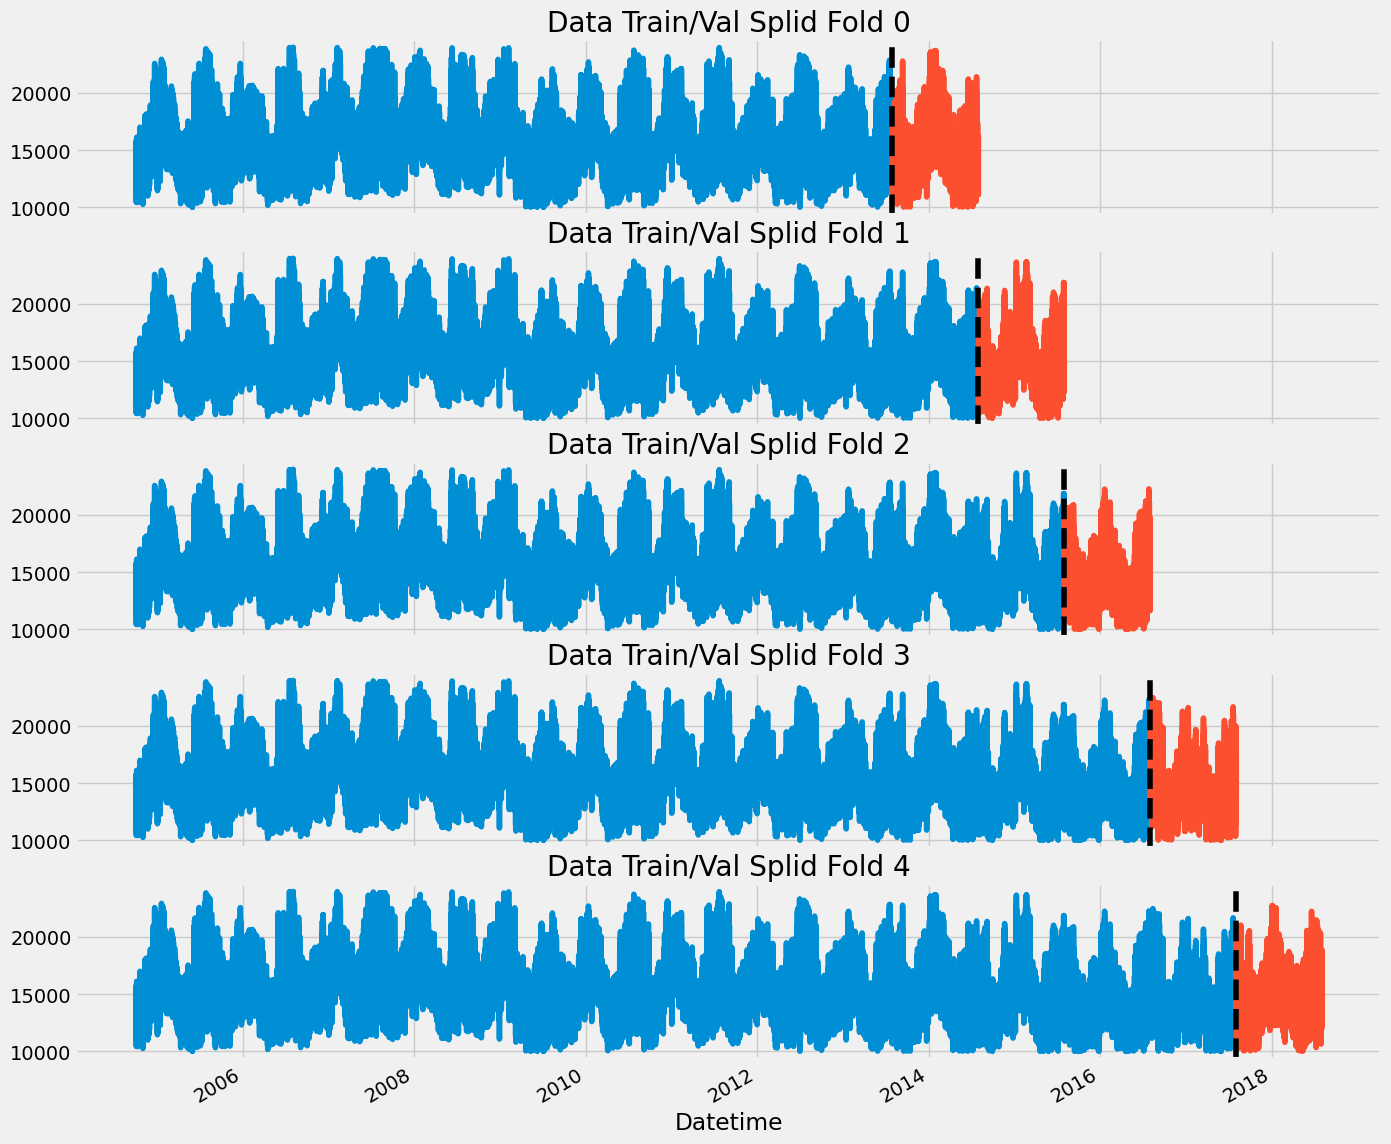

In [67]:
fig, axs = plt.subplots(5,1
                        , figsize=(15,15)
                        ,sharex=True)

fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    train['AEP_MW'].plot(ax=axs[fold]
                         ,label= 'Training Set'
                         ,title= f'Data Train/Val Splid Fold {fold}')
    val['AEP_MW'].plot(ax=axs[fold]
                       , label='Val Set'
                       )
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold +=1
    
plt.show()



# Forecasting Horizon Explained

The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizonos ( one-three months) to long-term horizons(more than two years)

# 3. Lag Features
* What was the target(x) days in the past

In [68]:
target_map = df['AEP_MW'].to_dict()

In [69]:
def add_lag(df):
    df['lag1'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('730 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1095 days')).map(target_map)
    return df

def create_feature(df):
    """
    Create time series feature based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    return df

In [70]:
#check
df = add_lag(df)
df.tail(5)

,AEP_MW,lag1,lag2,lag3
Datetime,,,,
2018-08-02 20:00:00,17673.0,18495.0,19893.0,19000.0
2018-08-02 21:00:00,17303.0,17771.0,19317.0,18431.0
2018-08-02 22:00:00,17001.0,17220.0,18762.0,17990.0
2018-08-02 23:00:00,15964.0,16100.0,17421.0,16646.0
2018-08-03 00:00:00,14809.0,14812.0,15920.0,15134.0


In [71]:
#a year before matchs lag1
df['2017-08-02 20:00:00' : '2017-08-03 00:00:00']

,AEP_MW,lag1,lag2,lag3
Datetime,,,,
2017-08-02 20:00:00,18495.0,19893.0,19000.0,15975.0
2017-08-02 21:00:00,17771.0,19317.0,18431.0,15570.0
2017-08-02 22:00:00,17220.0,18762.0,17990.0,15543.0
2017-08-02 23:00:00,16100.0,17421.0,16646.0,14599.0
2017-08-03 00:00:00,14812.0,15920.0,15134.0,13516.0


In [72]:
df = create_feature(df)
df.columns

Index(['AEP_MW', 'lag1', 'lag2', 'lag3', 'hour', 'week', 'quarter', 'month',
       'year', 'dayofyear'],
      dtype='object')

# Train Using Cross Validation

* to be implemented Hyper-parameter tuning

In [73]:
tss = TimeSeriesSplit(n_splits=5
                      , test_size = 24*365*1
                      ,gap=24)

df = df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
   print(f'Training fold : {fold}')
   train = df.iloc[train_idx]
   val = df.iloc[val_idx]

   train = create_feature(train)
   val = create_feature(val)

   FEATURES = [ 'lag1', 'lag2', 'lag3', 'hour', 'week', 'quarter', 'month',
      'year', 'dayofyear']
   TARGET = 'AEP_MW'

   X_train = train[FEATURES]
   y_train = train[TARGET]

   X_val = val[FEATURES]
   y_val = val[TARGET]

   reg = xgb.XGBRegressor( n_estimators = 1000
                          , early_stopping_rounds = 10
                          )
   reg.fit(X_train, y_train
           , eval_set =[(X_train, y_train), (X_val, y_val)]
           , verbose = 10
           )

   y_pred = reg.predict(X_val)
   preds.append(y_pred)
   score = np.sqrt(mean_squared_error(y_val, y_pred))
   scores.append(score)

Training fold : 0
[0]	validation_0-rmse:11296.33531	validation_1-rmse:10790.43334
[10]	validation_0-rmse:1269.69976	validation_1-rmse:1594.00944
[20]	validation_0-rmse:1063.04391	validation_1-rmse:1551.79610
[28]	validation_0-rmse:991.47319	validation_1-rmse:1598.58939
Training fold : 0
[0]	validation_0-rmse:11253.67403	validation_1-rmse:10769.19732
[10]	validation_0-rmse:1291.85041	validation_1-rmse:1474.14880
[20]	validation_0-rmse:1092.80693	validation_1-rmse:1529.77634
[22]	validation_0-rmse:1077.42253	validation_1-rmse:1528.90411
Training fold : 0
[0]	validation_0-rmse:11214.71788	validation_1-rmse:10147.65649
[10]	validation_0-rmse:1300.87608	validation_1-rmse:1497.58717
[18]	validation_0-rmse:1146.37550	validation_1-rmse:1569.74249
Training fold : 0
[0]	validation_0-rmse:11145.94873	validation_1-rmse:10387.20729
[10]	validation_0-rmse:1327.96747	validation_1-rmse:1731.43242
[20]	validation_0-rmse:1128.30856	validation_1-rmse:1665.44670
[30]	validation_0-rmse:1057.08498	validatio

In [74]:
print(f'Score avrage {np.mean(scores):0.4f}')
print(scores)

Score avrage 1587.2201
[1546.8583160810238, 1449.4183708558999, 1473.3670494032494, 1643.6472330728789, 1822.8095159550617]


### Predicting the Future

* Retrain on all data
* Create a future empty dataframe

In [76]:
df = create_feature(df)
df = add_lag(df)

FEATURES = [ 'lag1', 'lag2', 'lag3', 'hour', 'week', 'quarter', 'month',
    'year', 'dayofyear']
TARGET = 'AEP_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor( n_estimators = 20
                       #   , early_stopping_rounds = 10
                          )
reg.fit(X_all, y_all)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Create future dataframe

In [78]:
df.index.max()


Timestamp('2018-08-03 00:00:00')

In [82]:

future = pd.date_range('2018-08-03', '2019-09-03', freq= '1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_feature(df_and_future)
df_and_future = add_lag(df_and_future)


In [85]:
future_w_feature = df_and_future.query('isFuture').copy()

In [86]:
future_w_feature['pred'] = reg.predict(future_w_feature[FEATURES])

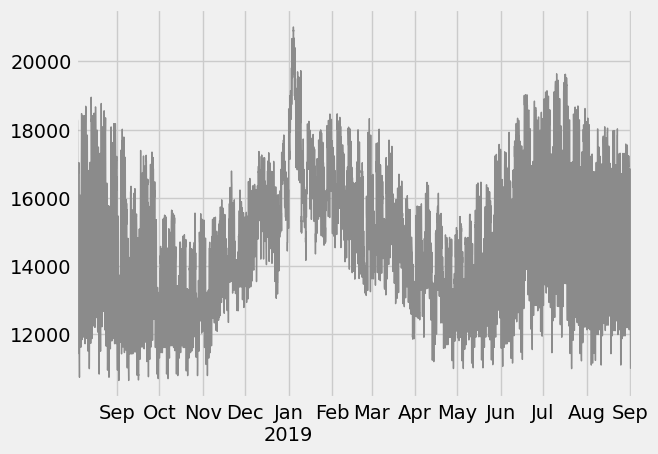

In [88]:
future_w_feature['pred'].plot(
                            color =color_pal[4]
                            , ms =1
                            , lw =1

)

plt.show()